# Salary prediction App 


## Predicting developer salaries from Stack Overflow survey data using years of experience and location

### Importing libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pickle 

### Reading data

In [42]:
df = pd.read_csv("./Data/survey_results_public.csv")

### Exploring data

In [43]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

### Data Cleaning

- We are only going to consider the following columns; country, EdLevel, YearsCodePro, ConvertedComp (salary) as we are predicting salary based on years of experience and location.

In [45]:
df = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]
df = df.rename({"ConvertedComp": "Salary"}, axis=1)
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
0,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Independent contractor, freelancer, or self-em...",NaN
1,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Employed full-time,NaN
2,Russian Federation,NaN,NaN,NaN,NaN
3,Albania,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,NaN,NaN
4,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,Employed full-time,NaN


- We are selecting the rows where the salary is not null.

In [46]:
df = df[df["Salary"].notnull()]
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
7,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,Employed full-time,116000.0
9,United Kingdom,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,Employed full-time,32315.0
10,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,Employed full-time,40070.0
11,Spain,Some college/university study without earning ...,7,Employed full-time,14268.0
12,Netherlands,"Secondary school (e.g. American high school, G...",20,Employed full-time,38916.0


- Droping the all the columns with atleast one null value.

In [47]:
df = df.dropna()
df.isnull().sum()

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

In [48]:
df = df[df["Employment"] == "Employed full-time"]
df = df.drop("Employment", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30019 entries, 7 to 64154
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       30019 non-null  object 
 1   EdLevel       30019 non-null  object 
 2   YearsCodePro  30019 non-null  object 
 3   Salary        30019 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


- preparing data

In [49]:
df['Country'].value_counts()

United States     7569
India             2425
United Kingdom    2287
Germany           1903
Canada            1178
                  ... 
Benin                1
Fiji                 1
San Marino           1
Guinea               1
Andorra              1
Name: Country, Length: 154, dtype: int64

In [50]:
# we want the countries with more than 300 respondents

def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

country_map = shorten_categories(df.Country.value_counts(), 300)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Other                 7922
United States         7569
India                 2425
United Kingdom        2287
Germany               1903
Canada                1178
Brazil                 991
France                 972
Spain                  670
Australia              659
Netherlands            654
Poland                 566
Italy                  560
Russian Federation     522
Sweden                 514
Turkey                 327
Israel                 300
Name: Country, dtype: int64

### Visualizing data

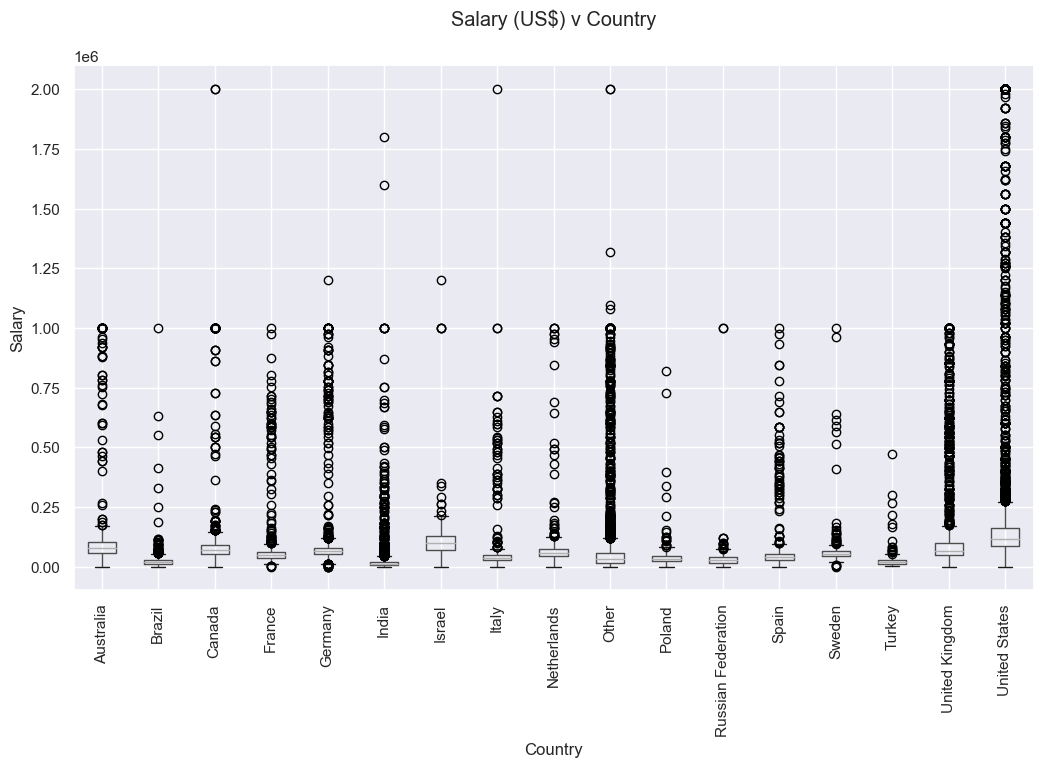

In [51]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()


In [52]:
# we are only considering the salary 300000 and below 

df = df[df["Salary"] <= 250000]
df = df[df["Salary"] >= 6000]
df = df[df['Country'] != 'Other']

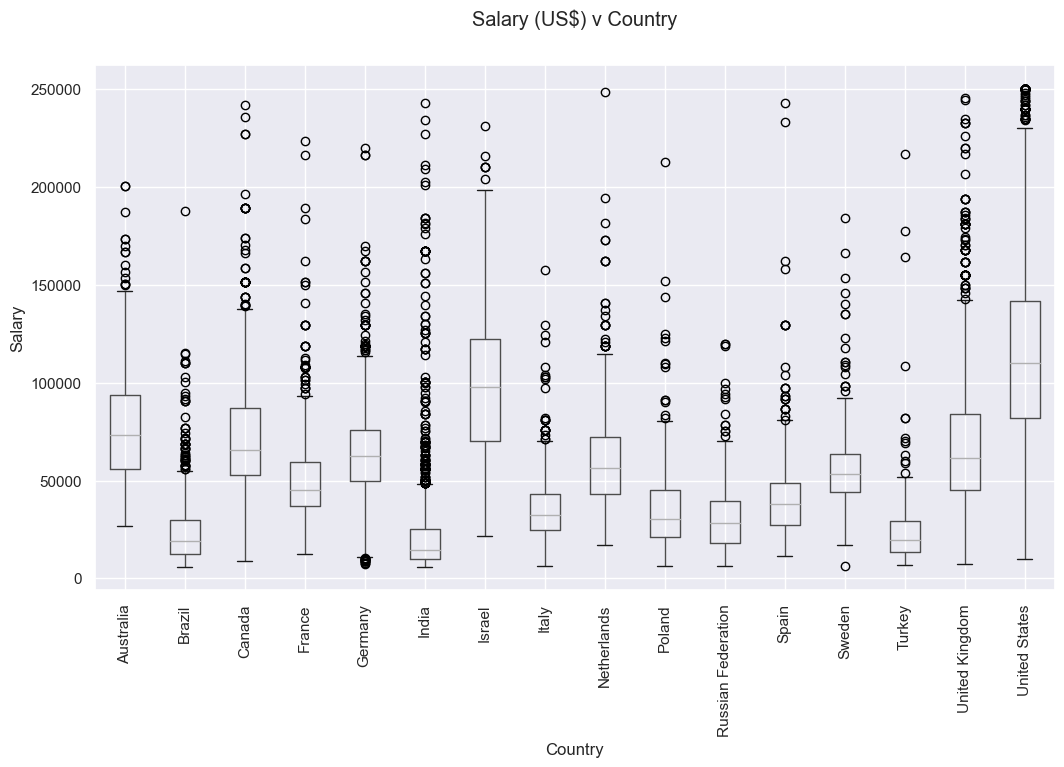

In [53]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

- Cleaning experience column

In [54]:
df["YearsCodePro"].unique()

array(['13', '4', '2', '7', '20', '1', '3', '10', '12', '29', '6', '28',
       '8', '23', '15', '25', '9', '11', 'Less than 1 year', '5', '21',
       '16', '18', '14', '32', '19', '22', '38', '30', '26', '27', '17',
       '24', '34', '35', '33', '36', '40', '39', 'More than 50 years',
       '31', '37', '41', '45', '42', '44', '43', '50', '49'], dtype=object)

In [55]:
def clean_experience(x):
    if x ==  'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

df['YearsCodePro'] = df['YearsCodePro'].apply(clean_experience)

- Education

In [56]:
df["EdLevel"].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'I never completed any formal education',
       'Primary/elementary school'], dtype=object)

In [57]:
def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)

In [58]:
df["EdLevel"].unique()

array(['Bachelor’s degree', 'Master’s degree', 'Less than a Bachelors',
       'Post grad'], dtype=object)

In [59]:
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])
df["EdLevel"].unique()

array([0, 2, 1, 3])

In [60]:
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df["Country"].unique()

array([15, 14, 11,  8,  4,  2,  7,  1,  3,  5,  6, 12, 13,  9,  0, 10])

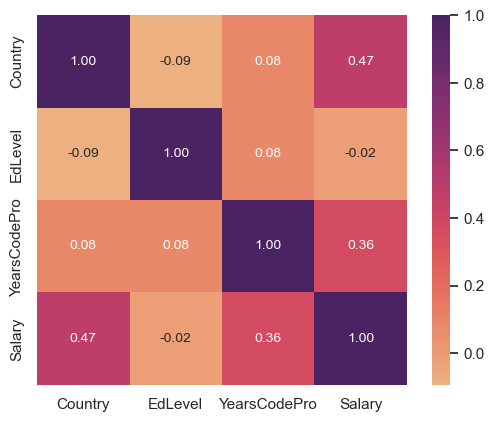

In [61]:
corrmat = df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=df.columns, 
                 xticklabels=df.columns, 
                 cmap="flare")
plt.show()

**This heatmap shows the correlation between the columns**

- Salary is highly correlated with years of experience (Positive correlation)
- Salary is correlated with country (positive correlation)
- salary is not correlated with education level (negative correlation)

**The negative correlation between salary and education level is not what something we would expect. This is may be due multiple reasons;**

- The survey data is not representative of the population
- People with higher education may less likely to respond to the survey
- People with higher education may be more likely go into management, Teaching, or other non-coding roles

In [62]:
X = df.drop("Salary", axis=1)
y = df["Salary"]

### Trying different models

#### Linear Regression

In [63]:
linear_reg = LinearRegression()
linear_reg.fit(X, y.values)

y_pred = linear_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$39,794.42


**RMSE using Linear Regression is : 39, 794**

### Decision Tree Regression

In [64]:
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(X, y.values)

y_pred = dec_tree_reg.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$28,849.94


**RMSE using Decision Tree Regression is : 28849**

### Random Forest Regression

In [65]:
random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X, y.values)

y_pred = random_forest_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$28,929.82


**RMSE using random forest regression is : 28929.82**

In [66]:
from sklearn.svm import SVR


svr_reg = SVR(kernel='rbf')
svr_reg.fit(X, y.values)

y_pred = svr_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$48,717.44


**RMSE using Support Vector Regression is :  48717.44**

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_reg = GradientBoostingRegressor(random_state=0)
gbr_reg.fit(X, y.values)

y_pred = gbr_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$30,218.74


**RMSE using Gradient boosting Regressor is :  30, 218.74**

In [68]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(random_state=0)
ada_reg.fit(X, y.values)


y_pred = ada_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$35,668.83


**RMSE using AdaBoost Regressor is :  35, 668.83**

In [69]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(random_state=0)
bag_reg.fit(X, y.values)

y_pred = bag_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))



$29,021.73


**RMSE using Bagging Regressor is :  30, 29021**

In [70]:
from sklearn.ensemble import ExtraTreesRegressor

extra_reg = ExtraTreesRegressor(random_state=0)
extra_reg.fit(X, y.values)

y_pred = extra_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$28,849.94


**RMSE using Extra Trees Regressor is :  28849**

In [71]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(estimators=[('lr', linear_reg), ('dt', dec_tree_reg), ('rf', random_forest_reg), ('svr', svr_reg), ('gbr', gbr_reg), ('ada', ada_reg), ('bag', bag_reg), ('extra', extra_reg)])
voting_reg.fit(X, y.values)

y_pred = voting_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$30,566.07


**RMSE using Voting Regressor is :  30566**

### Using Grid Search to find the best parameters

In [72]:
max_depth = [None, 5, 10, 15, 20, 25, 30]
parameters = {"max_depth": max_depth}

regressor = DecisionTreeRegressor(random_state=0)
gs = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error')
gs.fit(X, y.values)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 5, 10, 15, 20, 25, 30]},
             scoring='neg_mean_squared_error')

In [73]:
regressor = gs.best_estimator_

regressor.fit(X, y.values)
y_pred = regressor.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$29,579.46


In [74]:
# country, edlevel, yearscode
X = np.array([["India", 'Master’s degree', 15 ]])
X

array([['India', 'Master’s degree', '15']], dtype='<U15')

In [75]:
X[:, 0] = le_country.transform(X[:,0])
X[:, 1] = le_education.transform(X[:,1])
X = X.astype(float)
X

array([[ 5.,  2., 15.]])

In [76]:
# Test the model
X = np.array([["India", 'Master’s degree', 15 ]])

X[:, 0] = le_country.transform(X[:,0])
X[:, 1] = le_education.transform(X[:,1])
X = X.astype(float)

y_pred = regressor.predict(X)
y_pred

c:\Users\kanna\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([35558.96666667])

### Saving the model

- We have to save the model to use it in the web app. We are going to use pickle to save the model. The model would be solved using ```pickle``` Module. pickle would save the model using a technique called serialization. Serialization is the process of converting an object into a stream of bytes to store the object or transmit it to memory, a database, or a file. Its main purpose is to save the state of an object in order to be able to recreate it when needed. The reverse operation is called deserialization.

In [77]:
data = {"model": regressor, "le_country": le_country, "le_education": le_education}
with open('model_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
with open('model_data.pkl', 'rb') as file:
    data = pickle.load(file)

regressor_loaded = data["model"]
le_country = data["le_country"]
le_education = data["le_education"]

In [ ]:
y_pred = regressor_loaded.predict(X)
y_pred